# MACHINE LEARNING I
# 
# LAB ASSIGNMENT I: CLASSIFICATION

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: 202308780@alu.comillas.edu

In this lab assignment, we will analyze the FICO_Dataset.csv dataset and extract conclusions, performing several classification methods properly explained.

---

In [240]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

# Others
from mltools import classification_tools as CT
import math
from mltools import model_tools as MT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [241]:
warnings.filterwarnings("ignore")  # No se muestran los warnings 


---

## 1. Preparing the Dataset

First of all, we start by loading the dataset and taking a look at the first 10 rows, shape of the DataFrame and type of columns in order to understand the variables.

### STEP 1: IMPORT DATASET

In [242]:
### Load file --------------------------------------------
df2 = pd.read_csv('FICO_dataset_reduced_MOD.csv', sep = ";")
df2.head()

,RiskPerformance,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
0,1.0,55,33,84,144.0,69.0,43,20.0,23.0,83,0
1,1.0,61,0,41,58.0,0.0,67,2.0,7.0,100,0
2,1.0,67,53,24,66.0,86.0,44,9.0,9.0,100,0
3,1.0,66,72,73,169.0,91.0,57,28.0,30.0,93,0
4,1.0,81,51,132,333.0,80.0,25,12.0,12.0,100,0


In [243]:
print("Shape of the DataFrame = ", df2.shape)

Shape of the DataFrame =  (7442, 11)


As we can see, there are 11 variables. Of those 11, 10 are independent, including:

- **ExternalRiskEstimate**: A measure of borrower's riskiness based on consolidated external data sources.

- **NetFractionRevolvingBurden**: The proportion of an individual's current credit usage compared to their maximum allowed credit.

- **AverageMInFile**: The average duration, in months, of the trades in a borrower's credit file.

- **MSinceOldestTradeOpen**: The age, in months, of a borrower's oldest credit account.

- **PercentTradesWBalance**: The percentage of trades with positive balance. ?

- **PercentInstallTrades**: The percentage of a borrower's credit accounts that have fixed payment terms over a specified period.

- **NumSatisfactoryTrades**: Count of trades where a borrower has met obligations satisfactorily.

- **NumTotalTrades**: Number of Total Trades (total number of credit accounts).

- **MSinceMostRecentInqexcl7days**: Months since the last credit inquiry, ignoring the most recent week.

- **PercentTradesNeverDelq**: The percentage of a borrower's trades with no history of delinquency.

Therefore, the variable to be predicted is:

- **RiskPerformance**: Paid as negotiated flag (12-36 months). Class variable (0 or 1).

### STEP 2: CHECK OUT THE MISSING VALUES

In [244]:
### Info and type of variables & missing
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          7442 non-null   int64  
 2   NetFractionRevolvingBurden    7442 non-null   int64  
 3   AverageMInFile                7442 non-null   int64  
 4   MSinceOldestTradeOpen         7415 non-null   float64
 5   PercentTradesWBalance         7386 non-null   float64
 6   PercentInstallTrades          7442 non-null   int64  
 7   NumSatisfactoryTrades         7425 non-null   float64
 8   NumTotalTrades                7419 non-null   float64
 9   PercentTradesNeverDelq        7442 non-null   int64  
 10  MSinceMostRecentInqexcl7days  7442 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 639.7 KB


We can observe that there are several missing values. Most of them are in our response variable, so we have to delete those observations (impute values in that column could be dangerous because it will affect the results of all models). Appart from that, it is also necessary to change the type of this variable, and also we could reassign the type of the *float64* ones to *int64* but it's not mandatory.

In [245]:
### Basic removal of missing values
df = df2.dropna(subset=['RiskPerformance'], inplace=False) #Inplace for "really" elminiating the rows in the dataframe

#Check results
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5218 non-null   float64
 5   PercentTradesWBalance         5189 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5228 non-null   float64
 8   NumTotalTrades                5222 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


It seems that the rest of the missing values (around 100) belong to other variables. We could delete them, but we would lose information for the rest of values in the observations. So is that, we impute that missings with the k-nearest neighbors function from scikit-learn.

In [246]:
columns_with_missing_values = df.columns[df.isnull().any()].tolist()

imputer = KNNImputer(n_neighbors=10) #Number of neighbors could be changed

# Impute missing values
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5245 non-null   float64
 5   PercentTradesWBalance         5245 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5245 non-null   float64
 8   NumTotalTrades                5245 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


### STEP 3: ENCODE VARIABLES

In [247]:
#There are no categorical input variables

### Convert output variable to factor
df.RiskPerformance = df.RiskPerformance.astype('category')

### Convert float64 variables to int64
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].apply(lambda x: x.astype('int64'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5245 non-null   category
 1   ExternalRiskEstimate          5245 non-null   int64   
 2   NetFractionRevolvingBurden    5245 non-null   int64   
 3   AverageMInFile                5245 non-null   int64   
 4   MSinceOldestTradeOpen         5245 non-null   int64   
 5   PercentTradesWBalance         5245 non-null   int64   
 6   PercentInstallTrades          5245 non-null   int64   
 7   NumSatisfactoryTrades         5245 non-null   int64   
 8   NumTotalTrades                5245 non-null   int64   
 9   PercentTradesNeverDelq        5245 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 456.0 KB


### STEP 4: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

In [248]:
# Data types
df.describe()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000
mean,71.103718,34.584747,77.130219,200.537464,65.599428,34.668255,21.119161,22.823832,91.310391,2.186654
std,12.535667,29.076478,33.535254,99.076681,22.654030,17.413723,11.272021,12.206065,15.159203,4.994205
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,64.000000,9.000000,57.000000,135.000000,50.000000,22.000000,13.000000,15.000000,89.000000,0.000000
50%,72.000000,29.000000,75.000000,185.000000,67.000000,33.000000,20.000000,21.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,259.000000,82.000000,46.000000,27.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,100.000000,78.000000,100.000000,100.000000,24.000000


As we can see, there are negative values that stand out. According to the information given, there are 3 possible scenarios:

- **-9**: No Bureau Record or No Investigation.

- **-8**: No Usable/Valid Trades or Inquiries.

- **-7**: Condition not Met (e.g. No Inquiries, No Delinquencies).

Therefore, if a **-9** appears in any row, it should be replaced. Nonetheless, if we take a look at the *.csv* file, we can see that there are around 50 rows that all of the values for the independent variables are **-9**, so we can proceed by deleting those rows.

In [249]:
df = df[(df != -9).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5195 entries, 0 to 7391
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5195 non-null   category
 1   ExternalRiskEstimate          5195 non-null   int64   
 2   NetFractionRevolvingBurden    5195 non-null   int64   
 3   AverageMInFile                5195 non-null   int64   
 4   MSinceOldestTradeOpen         5195 non-null   int64   
 5   PercentTradesWBalance         5195 non-null   int64   
 6   PercentInstallTrades          5195 non-null   int64   
 7   NumSatisfactoryTrades         5195 non-null   int64   
 8   NumTotalTrades                5195 non-null   int64   
 9   PercentTradesNeverDelq        5195 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5195 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 451.6 KB


,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000
mean,71.874687,35.004235,77.959192,202.554187,66.317421,35.088547,21.409047,23.130125,92.275842,2.294321
std,9.812837,28.898398,32.608875,97.385605,21.541998,16.959460,10.929992,11.856607,11.585244,4.895500
min,33.000000,-8.000000,4.000000,-8.000000,-8.000000,0.000000,0.000000,1.000000,0.000000,-8.000000
25%,64.000000,9.000000,57.000000,137.000000,50.000000,22.000000,13.000000,15.000000,89.000000,0.000000
50%,72.000000,30.000000,75.000000,186.000000,67.000000,33.000000,20.000000,22.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,260.500000,82.000000,46.000000,28.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,100.000000,78.000000,100.000000,100.000000,24.000000


Besides, there are also around 50 observations (2 of them with this value repeated) in different variables having **-8** as a value. Due to the fact that this number implies that there are no valid trades, we delete those rows, as in the previous case. It could be possible also to impute them, but the few observations affected and all the work that has to be done in order to do it correctly (maybe searching for a variable with correlation to use regression or a deep understanding of the variable and its relationship with the rest of them) indicates that eliminating the rows may be a better solution.

In [250]:
df = df[(df != -8).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5145 non-null   category
 1   ExternalRiskEstimate          5145 non-null   int64   
 2   NetFractionRevolvingBurden    5145 non-null   int64   
 3   AverageMInFile                5145 non-null   int64   
 4   MSinceOldestTradeOpen         5145 non-null   int64   
 5   PercentTradesWBalance         5145 non-null   int64   
 6   PercentInstallTrades          5145 non-null   int64   
 7   NumSatisfactoryTrades         5145 non-null   int64   
 8   NumTotalTrades                5145 non-null   int64   
 9   PercentTradesNeverDelq        5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5145 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 447.3 KB


,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000
mean,71.819048,35.175510,77.829155,202.413605,66.280078,35.010496,21.459475,23.181147,92.267444,2.374927
std,9.802586,28.869156,32.555655,97.201973,21.480005,16.853058,10.918579,11.851869,11.561419,4.835027
min,33.000000,0.000000,4.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-7.000000
25%,64.000000,9.000000,57.000000,137.000000,50.000000,22.000000,14.000000,15.000000,89.000000,0.000000
50%,72.000000,30.000000,75.000000,186.000000,67.000000,33.000000,20.000000,22.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,260.000000,82.000000,46.000000,28.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,94.000000,78.000000,100.000000,100.000000,24.000000


The last strange value is **-7**, which implies that the condition of the column is not met. As we can see, it only appears in the months since the most recent credit inquiry, meaning that there has never been an inquiry in that line of credit. We have again two options, but here it could be better to impute the values, because the degree of depth of understanding necessary for this and the rest of the variables is less than the previous case. 

The idea is to replace the values with an extremely (yet logical) high value, and add a binary column indicating if there has been an inquiry in the line of credit. Obviously this new variable would be used in nearly all the models of the assignment (in LDA and QDA is not possible). 

The maximum value is 24 months, so we can change all **-7** observations for **24** months. However, maybe the line of credit was opened after 24 months, so maybe it is better to convert the column into a categorical one. To prove this, we plot an histogram to observe its distribution.

Anyway, we will also change the -7 observations for 24 months in the cases it makes sense and for the maximum logical value in the rest of the cases. We do this, as in some models we create in the future, it might be interesting to have only quantitative variables.

In [251]:
df.columns

df['MSinceMostRecentInqexcl7days'].describe()

count    5145.000000
mean        2.374927
std         4.835027
min        -7.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        24.000000
Name: MSinceMostRecentInqexcl7days, dtype: float64

In [252]:
MSinceMostRecentInqexcl7daysN=df['MSinceMostRecentInqexcl7days']
 
     
for i in MSinceMostRecentInqexcl7daysN.index:
    
    if MSinceMostRecentInqexcl7daysN[i]==-7:
        MSinceMostRecentInqexcl7daysN[i] = min(df['MSinceOldestTradeOpen'][i],24)
 

This variable 'MSinceMostRecentInqexcl7daysN' will be the one that will be used in the models that only include quantitative values

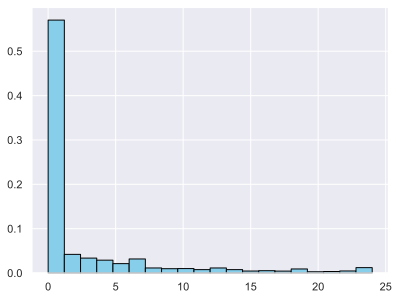

In [253]:
plt.hist(df['MSinceMostRecentInqexcl7days'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

We can see that the frequency is a lot higher in one or two of the values. For that reason, and bearing in mind the previous study with **-7**, we change this variable to a categorical one.

In [254]:
# Creation of the categorical variable MSinceMostRecentInqexcl7days
conditions = [
    (df['MSinceMostRecentInqexcl7days'] < 1) & (df['MSinceMostRecentInqexcl7days'] >= 0),
    (df['MSinceMostRecentInqexcl7days'] <= 6) & (df['MSinceMostRecentInqexcl7days'] >= 1),
    (df['MSinceMostRecentInqexcl7days'] <= 12) & (df['MSinceMostRecentInqexcl7days'] > 6),
    (df['MSinceMostRecentInqexcl7days'] > 12),
    (df['MSinceMostRecentInqexcl7days'] == -7)
]

choices = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']

df['MSinceMostRecentInqexcl7days'] = np.select(conditions, choices, default='Unknown')

df.MSinceMostRecentInqexcl7days = df.MSinceMostRecentInqexcl7days.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5145 non-null   category
 1   ExternalRiskEstimate          5145 non-null   int64   
 2   NetFractionRevolvingBurden    5145 non-null   int64   
 3   AverageMInFile                5145 non-null   int64   
 4   MSinceOldestTradeOpen         5145 non-null   int64   
 5   PercentTradesWBalance         5145 non-null   int64   
 6   PercentInstallTrades          5145 non-null   int64   
 7   NumSatisfactoryTrades         5145 non-null   int64   
 8   NumTotalTrades                5145 non-null   int64   
 9   PercentTradesNeverDelq        5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5145 non-null   category
dtypes: category(2), int64(9)
memory usage: 541.4 KB


After fixing all the strange values, we can proceed to plot some graphics searching for other outliers, and visualizing the distribution.

In [255]:
Independent_vars = df.columns[(df.columns != 'RiskPerformance')]
Independent_vars_cuant = df.columns[df.dtypes != 'category']

# Definition of the rows and columns for the plot
num_rows = len(Independent_vars_cuant) // 3  #Now there are 9 cuantitative variables
num_cols = 3

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    axs[row, col].hist(df[var], bins=20, color='skyblue', edgecolor='black', density=True) #Number of bins could be changed
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In the last histogram we can observe a similar behaviour to the variable `MSinceMostRecentInqexcl7days`, but here it could be more interesting to keep this variable as a quantitative one (for future models). For that reason, we use a BoxCox transformation for that variable.

In [256]:
from scipy.stats import boxcox

df['PercentTradesNeverDelq'] = boxcox((df['PercentTradesNeverDelq'] + 0.0001))[0] #To ensure that all data is positive

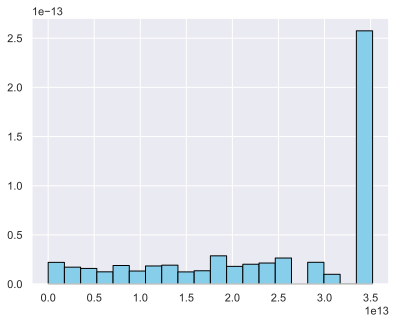

In [257]:
plt.hist(df['PercentTradesNeverDelq'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

This is the maximum normality we can get. Obviously it is not the desired, but we cannot use more transformations.

In the rest of the columns, we cannot see any clear outliers or strange observations. Therefore, we proceed representing several boxplots and scatterplots of the variables.

In [258]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.boxplot(x=df[var], ax=axs[row, col], color='skyblue')
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, there are several outliers and most of them are skewed distributions. Nonetheless, there are not strange enough to think about replacing or deleting them. To finish things off, we represent the 2 categorical variables, in order to spot strange behaviours.

In [259]:
num_rows = 1  #2 categorical variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Loop in charge of representing histograms
#for i, var in enumerate(['RiskPerformance', 'MSinceMostRecentInqexcl7days']):
#    col = i % num_cols
#    ax = axs[col]
#    df[var].value_counts(normalize=True).plot.bar(rot=0, xlabel=var, ax=ax, ylabel ='Frequency', color = 'Skyblue')
#    ax.tick_params(axis='x', labelsize=9)

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

The results are the expected, so we can continue.

### STEP 5: EXPLORATORY ANALYSIS

First, we are going to represent a brief study between the dependent variable `RiskPerformance` and the rest of all. We have several options, such as density curves, box plots, etc. Nevertheless, we are going to plot a group of violin plots, stip plots and histogram subplots based on the response variable (box plots and density curves contain the same information as the previous ones).

In [260]:
num_rows = len(Independent_vars_cuant) // 3  #Now there are 9 cuantitative variables
num_cols = 3

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.violinplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col])
#    axs[row, col].set_title(f'Boxplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [261]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.stripplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col], jitter=True)
#    axs[row, col].set_title(f'Boxplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [262]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.histplot(x=var, hue='RiskPerformance', data=df, ax=axs[row, col], kde=False, stat='probability')
#    axs[row, col].set_title(f'Boxplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel(var)
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

There are not independent quantitative variables with a strong relationship with our response variable, the clearest ones might be the first four (`ExternalRiskEstimate`, `NetFractionRevolvingBurden`, `AverageMInFile` and `MSinceOldestTradeOpen`), yet being a slight dependency.

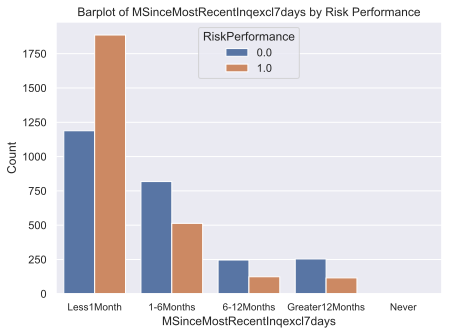

In [263]:
fig, ax = plt.subplots()
custom_order = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']
sns.countplot(x='MSinceMostRecentInqexcl7days', hue='RiskPerformance', data=df, order=custom_order)
ax.tick_params(axis='x', labelsize=10)
plt.xlabel('MSinceMostRecentInqexcl7days')
plt.ylabel('Count')
plt.title(f'Barplot of MSinceMostRecentInqexcl7days by Risk Performance')
plt.legend(title='RiskPerformance')

# Adjustment of design
plt.tight_layout()
# Graphic display
plt.show()

Observing the relationship between the two categorical variables we can deduce that there is a clear dependence, especially when the category is different from *Less1Month*.

In the previous section it could have been interesting to plot a pairplot, in order to spot outliers that the histograms and boxplots cannot mark. Nonetheless, with 9 quantitative variables (81 graphics), it is simply not possible to run the sentence along with the rest of the notebook. For that reason, after reviewing and searching for the most relationed variables with `RiskPerformance`, we represent a simplified pairplot.

In [264]:
# Scatterplot with the possibly most relationed variables with response
#plot = sns.pairplot(df.loc[:, ['RiskPerformance', 'ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 
#                        'MSinceOldestTradeOpen']], hue = 'RiskPerformance', height=2)
# Adjustment of design
#plt.tight_layout()
# Graphic display
#plt.show()

As we can see, there are no clear outliers, and the categories are really mixed.

The next task will be to study the possible relationship among independent variables, using a correlations plot and a pairplot, if possible. We have the same problem, so we study the pairplot for the most correlated variables.

In [265]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
#f = plt.figure()
#plt.matshow(df[Independent_vars_cuant].corr(), fignum=f.number, cmap='coolwarm')
#plt.xticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14, rotation=90)
#plt.yticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
#plt.show()

In [266]:
# Scatterplot with the most correlated variables. To run it, uncomment subsequent lines.

#sns.pairplot(df.loc[:, ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'MSinceOldestTradeOpen', 
#                               'NumSatisfactoryTrades', 'NumTotalTrades']], height=2)
#plt.tight_layout()
#plt.show()

We can appreciate that nearly all of them has little or no relationship with others. However, there are a few exceptions such as:

- **NumSatisfactoryTrades VS NumTotalTrades**: It seems pretty obvious because more trades will cause more satisfactory trades.

- **AverageMInFile VS MSinceOldestTradeOpen**: Similar to the previous one. More months in file is related with the months of your oldest trade.

- **ExternalRiskEstimate VS NetFractionRevolvingBurden**: It will be reasonable to have a lower `ExternalRiskEstimate` with a higher `NetFractionRevolvingBurden`, because it is easier for that specific sector to have paying problems.

### STEP 6: CHECK OUT FOR CLASS IMBALANCES

In [267]:
# Class count
df['RiskPerformance'] = df['RiskPerformance'].replace({0: "NO", 1: "YES"}) #Not paid/paid
df['RiskPerformance'].value_counts()

RiskPerformance
YES    2639
NO     2506
Name: count, dtype: int64

As we can see, our dependent variable is nearly perfectly balanced. So is that, we can move onto the next segment.

### STEP 7: SPLIT THE DATA INTO TRAINING AND TEST SETS

We apply the methods learnt in class to split the data into training and test sets, preserving the distribution of the response variable, doing copies of the subsets to store them and dividing the categorical independent variable into n-1 dummies.

In [268]:
# Define input and output matrices
INPUTS = df.drop(columns=['RiskPerformance']).columns.tolist()
OUTPUT = 'RiskPerformance'
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

In [269]:
X_train.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month


In [270]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = y_test # We will call Y as output variable for simplicity

## 2. Training of Machine Learning models

### MODEL 1: LOGISTIC REGRESSION

We train our model for Logistic Regression. First, we normalize the variables to eliminate any advantages between our variables, ensuring that the model can learn fairly. Then, we train the model without any penalty, allowing it to learn without any restrictions.

In [271]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR_NUM = INPUTS.copy()
INPUTS_LR_NUM.remove('MSinceMostRecentInqexcl7days')
INPUTS_LR_CAT = ['MSinceMostRecentInqexcl7days'] 
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR_NUM), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_LR_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Model pipeline
LogReg_fit = Pipeline(steps=[('Prep', preprocessor), # Preprocess the variables when training the model
                        ('LogReg', LogisticRegression(penalty=None))])

# Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


Now, we calculate the accuracy of our model by repeating the training process 10 times and calculating the mean.

In [272]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7332435688469988

In [273]:
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991154 -0.315813  0.054501  0.311495  0.942518

Coefficients:
                                              Estimate
Intercept                                    -0.375331
ExternalRiskEstimate                         -0.634564
NetFractionRevolvingBurden                    0.355876
AverageMInFile                               -0.266657
MSinceOldestTradeOpen                         0.030671
PercentTradesWBalance                        -0.004719
PercentInstallTrades                          0.141008
NumSatisfactoryTrades                        -0.250803
NumTotalTrades                               -0.013348
PercentTradesNeverDelq                       -0.206337
MSinceMostRecentInqexcl7days_6-12Months      -0.070147
MSinceMostRecentInqexcl7days_Greater12Months -0.120087
MSinceMostRecentInqexcl7days_Less1Month       0.791466
                                              Estimate  Std. Err   t-value  \
Intercept    

As we can observe in the results, the deviance residual values could be improved, as they are not close enough to zero. When examining the coefficients, we can observe that the most significant variables are ExternalRiskEstimate, NetFractionRevolvingBurden, AverageMInFile, and MSinceMostRecentInqexcl7days. Additionally, other variables of significance include PercentInstallTrades, NumSatisfactoryTrades, and PercentTradesNeverDelq.

In [274]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,YES,NO,0.613299,0.386701
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,YES,NO,0.892464,0.107536
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,NO,NO,0.704449,0.295551
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,YES,YES,0.267609,0.732391
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,YES,YES,0.038389,0.961611


# --- REPRESENTARLO ESTA CHUNGO HAY Q PREGUNTAR DUDA ---

#### Step 9: CONFUSION MATRIX

We calculate the confusion matrix for the training dataset

In [275]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1460  545
      YES  541 1570

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.93
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


We calculate the confusion matrix for the test dataset

In [276]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_pred'],labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 342  159
      YES 133  395

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.14
Sensitivity: 0.75
Specificity: 0.68
Precision: 0.72
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.54
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


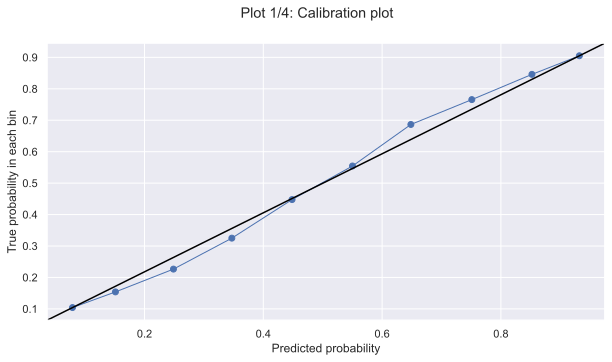

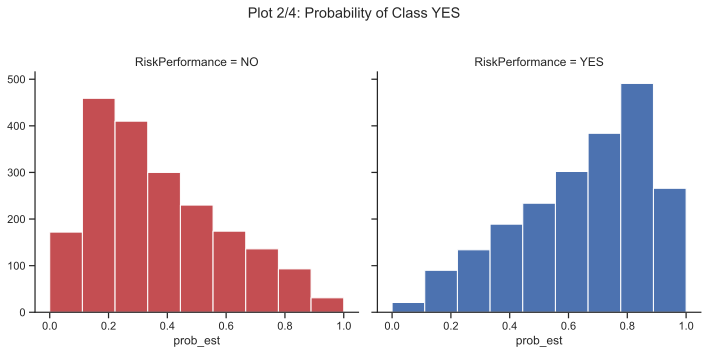

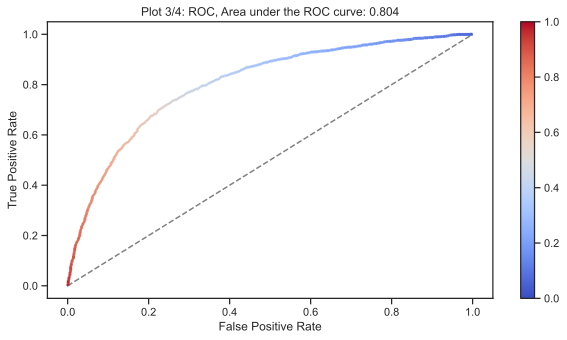

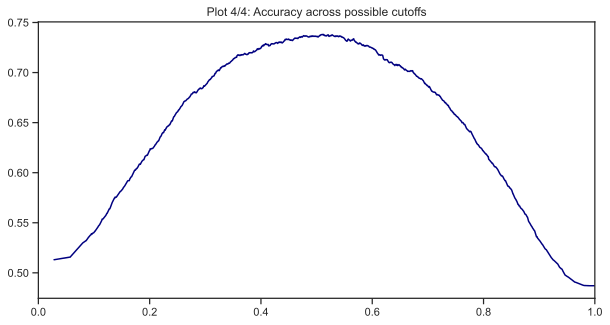

In [277]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass='YES')

As we can see in the plots, the result of this Logistic Regression model is underestimated, the ROC curve is not good enough

# ----TENGO Q BUSCAR CUAL ES EL MEJOR HE PROBADO Y DE MOMENTO ES ESTA COSA (JORGE)---- 

To improve the simplicity of our model, we will eliminate the following non-significant variables: MSinceOldestTradeOpen, PercentTradesWBalance, and NumTotalTrades. This simplification will make the model easier to understand and potentially improve its performance by reducing noise and complexity.

In [278]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS2_LR_NUM = INPUTS_LR_NUM.copy()
variables_nused = ['MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades']
for variable in variables_nused:
    INPUTS2_LR_NUM.remove(variable)

INPUTS2_LR_CAT = ['MSinceMostRecentInqexcl7days'] 
INPUTS2_LR = INPUTS2_LR_NUM + INPUTS2_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS2_LR_NUM), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS2_LR_CAT) # Apply the categorical_transformer to categorical inputs
        ])


#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model
                        ('LogReg',LogisticRegression(penalty=None))]) # Model to use in the pipeline

#Train model
LogReg_fit.fit(X_train[INPUTS2_LR], y_train);

print("Logistic Regression Trained")

Logistic Regression Trained


In [279]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS2_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7342132615217443

In [280]:
CT.summaryLogReg(LogReg_fit, X_train[INPUTS2_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991277 -0.314614  0.054539  0.313931  0.942541

Coefficients:
                                              Estimate
Intercept                                    -0.375662
ExternalRiskEstimate                         -0.633215
NetFractionRevolvingBurden                    0.353246
AverageMInFile                               -0.244481
PercentInstallTrades                          0.138693
NumSatisfactoryTrades                        -0.257674
PercentTradesNeverDelq                       -0.206251
MSinceMostRecentInqexcl7days_6-12Months      -0.067392
MSinceMostRecentInqexcl7days_Greater12Months -0.122848
MSinceMostRecentInqexcl7days_Less1Month       0.791988
                                              Estimate  Std. Err   t-value  \
Intercept                                    -0.375662  0.071153 -5.279677   
ExternalRiskEstimate                         -0.633215  0.068384 -9.259647   
NetFractionRevolvingBu

Now, we square the least significant variables and observe the results of the new logistic regression model.

In [281]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR2_NUM = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'NumSatisfactoryTrades']
INPUTS_LR2_SQ = ['PercentTradesNeverDelq', 'PercentInstallTrades'] 
INPUTS_LR2 = INPUTS_LR2_NUM + INPUTS_LR2_SQ

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the numeric variables by scaling
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR2_NUM), #Se aplica el numeric_transformer a los inputs num
        ('sq', square_transformer, INPUTS_LR2_SQ), #Se aplica el square_transformer a los inputs escalares
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(fit_intercept=False, penalty=None))]) # Avoid using intercept when using polynomial features

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LogReg_fit_sq.fit(X_train[INPUTS_LR2], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [282]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7252279545508231

In [283]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_, X_train[INPUTS_LR2], y_train)

Deviance Residuals:
       Min        1Q    Median       3Q       Max
0 -0.98987 -0.324594  0.060805  0.32604  0.924002

Coefficients:
                                             Estimate
ExternalRiskEstimate                        -0.653963
NetFractionRevolvingBurden                   0.363738
AverageMInFile                              -0.260815
NumSatisfactoryTrades                       -0.274502
1                                            0.020445
PercentTradesNeverDelq                      -0.227330
PercentInstallTrades                         0.116525
PercentTradesNeverDelq^2                    -0.019240
PercentTradesNeverDelq PercentInstallTrades  0.029297
PercentInstallTrades^2                       0.085494
                                             Estimate  Std. Err   t-value  \
ExternalRiskEstimate                        -0.653963  0.067070 -9.750458   
NetFractionRevolvingBurden                   0.363738  0.050420  7.214157   
AverageMInFile                          

In [284]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_train[INPUTS_LR2])
dfTR_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,0]
dfTR_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_test[INPUTS_LR2])
dfTS_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,0]
dfTS_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos,Y_LR_sq_pred,Y_LR_sq_prob_neg,Y_LR_sq_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,YES,NO,0.613299,0.386701,NO,0.515764,0.484236
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,YES,NO,0.892464,0.107536,NO,0.839077,0.160923
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,NO,NO,0.704449,0.295551,NO,0.624629,0.375371
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,YES,YES,0.267609,0.732391,YES,0.183333,0.816667
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,YES,YES,0.038389,0.961611,YES,0.040847,0.959153


# --- GRAFICOS HAY Q PREGUNTAR CUAL PONER ---

In [285]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_sq_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1431  574
      YES  557 1554

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.63
Sensitivity: 0.74
Specificity: 0.71
Precision: 0.72
Recall: 0.71
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.72
F1 Score: 0.72
Positive label: NO


In [286]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_sq_pred'], labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 352  149
      YES 141  387

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.68
Sensitivity: 0.73
Specificity: 0.7
Precision: 0.71
Recall: 0.7
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.72
F1 Score: 0.71
Positive label: NO


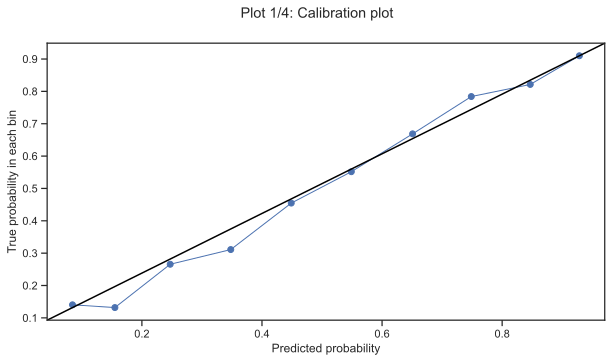

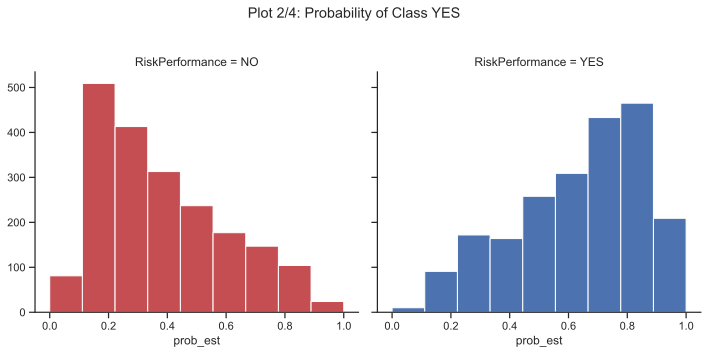

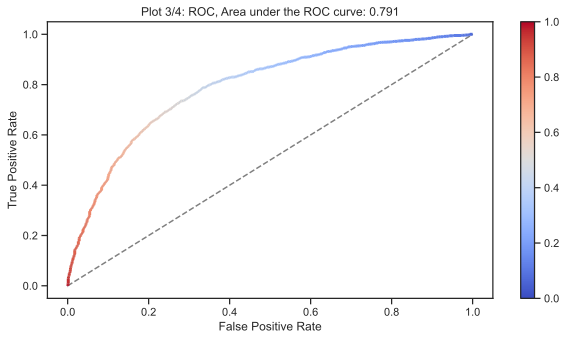

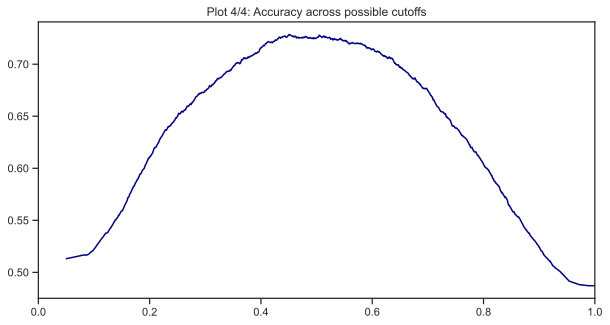

In [287]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2]), selClass='YES')

### MODEL 2: DISCRIMINANT ANALYSIS (DA)

Before entering the next model prediction study (k-nn), we try another method used in prediction, but not covered in class. This method is called discriminant analysis, and it is mainly used in certain situations:

- When the response variable classes are clearly divided. In this case, logistic regression could be extremely unstable.
- If the sample size is small and the independent variables are distributed approximately as a normal, DA could be more stable.
- Thirdly, it is more used when the response variable is not dichotomous, instead of multivariable logistic regression.

Therefore, it seems a worse prediction method than the previous one, but let's check it.

Before starting, it is important to give a brief definition and explanation of its functioning. After that, we start by testing the normality of the predictors.

Discriminant Analysis is a classification technique whose objective is to obtain a function (or set) that could classify new observations by the nearest centroid and separate the classes, using a set of discriminant functions (usually linear or quadratic). It is important to point out that independency of dependent variables is recommended, as well as in most of the other methods.

In [288]:
from scipy.stats import normaltest 

# Dictionary to store normality test results
normality_results = {}

# Check normality for each feature
for var in Independent_vars_cuant:
    normality_results[var] = normaltest(df[var]).pvalue > 0.05 #Shapiro is better for smaller samples

# normality_results dictionary will indicate whether each feature is normally distributed or not
print(normality_results)


{'ExternalRiskEstimate': False, 'NetFractionRevolvingBurden': False, 'AverageMInFile': False, 'MSinceOldestTradeOpen': False, 'PercentTradesWBalance': False, 'PercentInstallTrades': False, 'NumSatisfactoryTrades': False, 'NumTotalTrades': False, 'PercentTradesNeverDelq': False}


In [289]:
from scipy.stats import probplot

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop to create Q-Q plots
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
    
    # Create Q-Q plot for the variable
#    probplot(df[var], plot=axs[row, col], fit=True)
    
#    axs[row, col].set_title(f'Q-Q Plot of {var}')
#    axs[row, col].set_xlabel('Theoretical Quantiles')
#    axs[row, col].set_ylabel('Sample Quantiles')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, the predictors are not normally distributed, neither analytically nor graphically. Therefore, the results obtained may be worse or less precise than others using K-Nearest Neighbors (KNN) or Support Vector Machine (SVM). Still, we will check the outputs.

In [290]:
from scipy.stats import boxcox

X_train_DA = X_train.copy()
X_test_DA = X_test.copy()

# Box-Cox transformation to the predictors 
for var in Independent_vars_cuant[Independent_vars_cuant != 'PercentTradesNeverDelq']:
    # We add 0.0001 to ensure that they are all positive variables
    X_train_DA[var] = boxcox(X_train_DA[var] + 0.0001)[0]
    X_test_DA[var] = boxcox(X_test_DA[var] + 0.0001)[0]


In [291]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LDA = Independent_vars_cuant 

#ModLDA = LinearDiscriminantAnalysis()
LDA_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LDA',LinearDiscriminantAnalysis())]) # Model to use in the pipeline

#Train model
LDA_fit.fit(X_train[INPUTS_LDA], y_train);

print("Linear Discriminant Analysis Trained")

Linear Discriminant Analysis Trained


In [292]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LDA_fit, X_train[INPUTS_LDA], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.726194694446413

In [293]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LDA_pred'] = LDA_fit.predict(X_train[INPUTS_LDA])
dfTR_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_train[INPUTS_LDA])[:,0]
dfTR_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_train[INPUTS_LDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LDA_pred'] = LDA_fit.predict(X_test[INPUTS_LDA])
dfTS_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_test[INPUTS_LDA])[:,0]
dfTS_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_test[INPUTS_LDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos,Y_LR_sq_pred,Y_LR_sq_prob_neg,Y_LR_sq_prob_pos,Y_LDA_pred,Y_LDA_prob_neg,Y_LDA_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,YES,NO,0.613299,0.386701,NO,0.515764,0.484236,NO,0.506142,0.493858
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,YES,NO,0.892464,0.107536,NO,0.839077,0.160923,NO,0.846204,0.153796
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,NO,NO,0.704449,0.295551,NO,0.624629,0.375371,NO,0.618638,0.381362
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,YES,YES,0.267609,0.732391,YES,0.183333,0.816667,YES,0.177061,0.822939
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,YES,YES,0.038389,0.961611,YES,0.040847,0.959153,YES,0.042947,0.957053


In [294]:
#Confusion matrix for Linear Discriminant Analysis
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LDA_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1446  559
      YES  561 1550

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.98
Sensitivity: 0.73
Specificity: 0.72
Precision: 0.72
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: NO


In [295]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LDA_pred'], labels=['NO', 'YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 356  145
      YES 142  386

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.91
Sensitivity: 0.73
Specificity: 0.71
Precision: 0.71
Recall: 0.71
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.72
F1 Score: 0.71
Positive label: NO


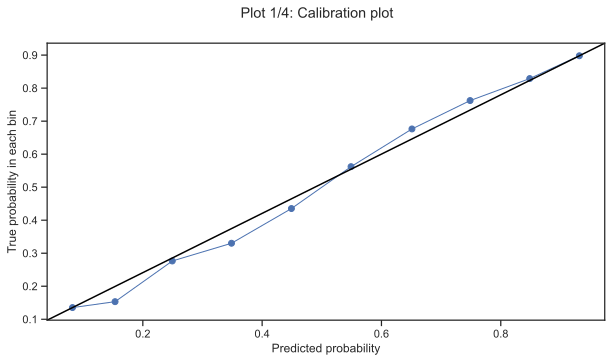

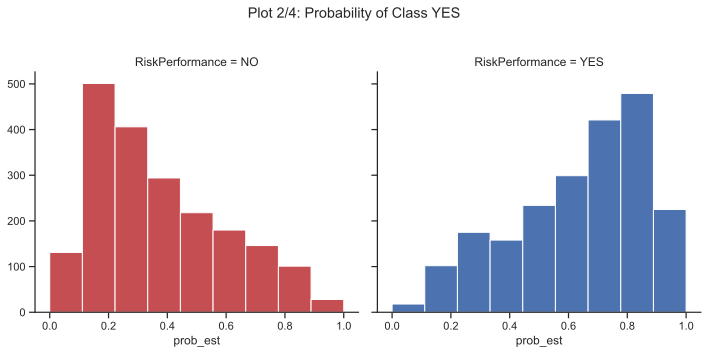

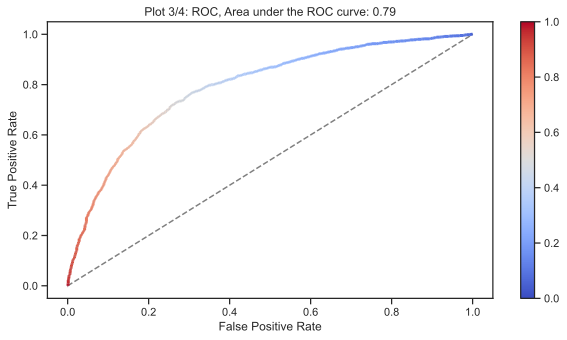

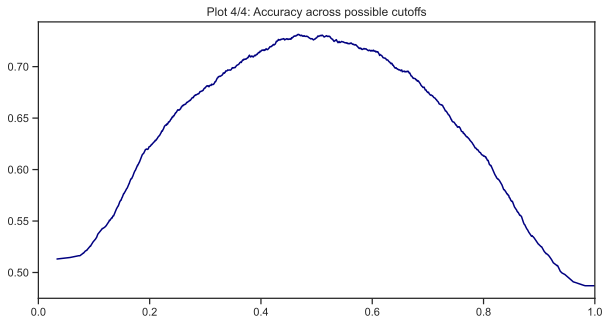

In [296]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LDA_fit.predict_proba(X_train[INPUTS_LDA]), selClass='YES')

The results are pretty similar to logistic regression (a little bit worse unless the test's specificity), indicating that probably none of them is good enough to predict our response variable. We now try using quadratic discriminant analysis, searching for better results.

In [297]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_QDA = Independent_vars_cuant 

#ModQDA = QuadraticDiscriminantAnalysis()
QDA_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('QDA',QuadraticDiscriminantAnalysis())]) # Model to use in the pipeline

#Train model
QDA_fit.fit(X_train[INPUTS_QDA], y_train);

print("Quadratic Discriminant Analysis Trained")

Quadratic Discriminant Analysis Trained


In [298]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(QDA_fit, X_train[INPUTS_QDA], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7099254718541091

In [299]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_QDA_pred'] = QDA_fit.predict(X_train[INPUTS_QDA])
dfTR_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_train[INPUTS_QDA])[:,0]
dfTR_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_train[INPUTS_QDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_QDA_pred'] = QDA_fit.predict(X_test[INPUTS_QDA])
dfTS_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_test[INPUTS_QDA])[:,0]
dfTS_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_test[INPUTS_QDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,...,Y_LR_prob_pos,Y_LR_sq_pred,Y_LR_sq_prob_neg,Y_LR_sq_prob_pos,Y_LDA_pred,Y_LDA_prob_neg,Y_LDA_prob_pos,Y_QDA_pred,Y_QDA_prob_neg,Y_QDA_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,...,0.386701,NO,0.515764,0.484236,NO,0.506142,0.493858,YES,0.397009,0.602991
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,...,0.107536,NO,0.839077,0.160923,NO,0.846204,0.153796,NO,0.833890,0.166110
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,...,0.295551,NO,0.624629,0.375371,NO,0.618638,0.381362,NO,0.594058,0.405942
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,...,0.732391,YES,0.183333,0.816667,YES,0.177061,0.822939,YES,0.144656,0.855344
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,...,0.961611,YES,0.040847,0.959153,YES,0.042947,0.957053,YES,0.007875,0.992125


In [300]:
#Confusion matrix for Quadratic Discriminant Analysis Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_QDA_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1319  686
      YES  495 1616

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.42
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.77
Specificity: 0.66
Precision: 0.73
Recall: 0.66
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.56
Balanced accuracy: 0.71
F1 Score: 0.69
Positive label: NO


In [301]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_QDA_pred'], labels=['NO', 'YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 322  179
      YES 136  392

Accuracy: 0.69
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.39
Mcnemar's Test P-Value: 0.02
Sensitivity: 0.74
Specificity: 0.64
Precision: 0.7
Recall: 0.64
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.55
Balanced accuracy: 0.69
F1 Score: 0.67
Positive label: NO


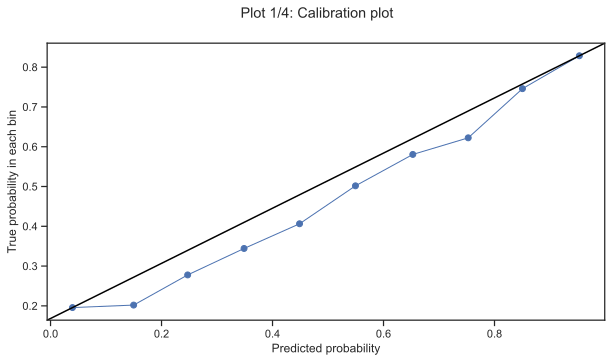

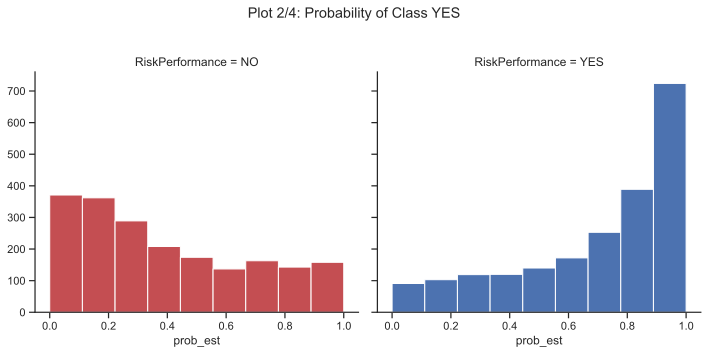

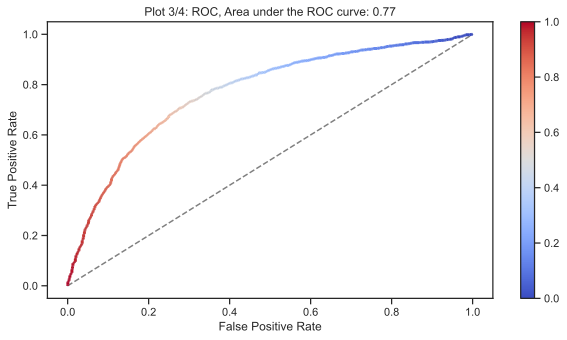

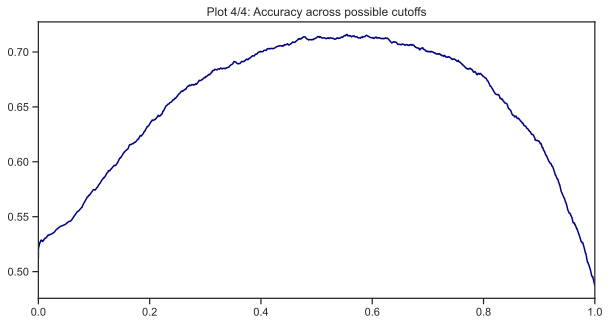

In [302]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], QDA_fit.predict_proba(X_train[INPUTS_QDA]), selClass='YES')

We observe that the results are even worse, especially for the classification of *NO* class in `RiskPerformance`.

### MODEL 3: K-NEAREST NEIGHBORS (KNN)

We move on to training a K-Nearest-Neighbours Model. The idea behind this algorithm is quite simple, however there are going to be a few characteristics of it that we need to work with carefully. 

In the previous models we have studied, there was no hyperparameter to consider, however this time, we will need to calculate(through CV) the number of neighbours that will turn out to produce the most accurate model we can get.

Unlike the two previous methods, where the own algorithm worked towards discovering which are the most meaningful variables in order to explain the variance in our response, in this case, the KNN gives equal importance to all the variables we include in the model. Due to that, we will have to study in more detail which variables are not being helpful, and adding noise to our model, as those will have a huge impact in our model.

However, we start by training an algorithm with all our variables and after it, we will decide if it is a good idea to remove any variable. We are going to train several models with different values of K(Number of neighbours considered), and analyze the results of accuracy of each model. All these values will be odd as this way we avoid draws between the 2 classes of our dependent variable. 

The other hyperparameter that takes part in the model is the number of folds we use in the CV, but for the whole document we will keep this value in 10.

#### 3.1: KNN without distance weights or variable selection

In [303]:
df['MSinceMostRecentInqexcl7daysN']=MSinceMostRecentInqexcl7daysN#Include the numeric variable in the dataset

# Inputs of the model. Change accordingly to perform variable selection
INPUTS_KNN = INPUTS.copy()
INPUTS_KNN.remove('MSinceMostRecentInqexcl7days')

INPUTS_KNN=INPUTS_KNN + ['MSinceMostRecentInqexcl7daysN'] 

X = df[INPUTS_KNN]

# Split again including the numeric variable
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

 



## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(9,559,10)} #Number of neighbors
 
# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier( ))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("kNN Trained")
 

kNN Trained


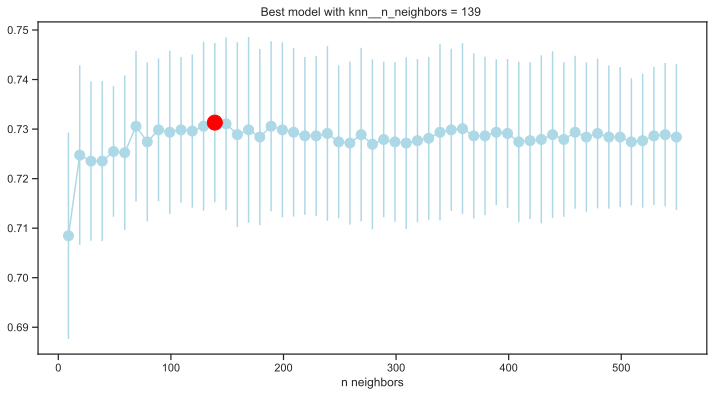

In [304]:
MT.plotModelGridError(knn_fit)

In [305]:
##Include the new numeric variable in dfTR_eval and dfTS_eval

dfTR_eval["MSinceMostRecentInqexcl7daysN"] = df["MSinceMostRecentInqexcl7daysN"]
dfTS_eval['MSinceMostRecentInqexcl7daysN']= df ["MSinceMostRecentInqexcl7daysN"]

## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

 As we can see, we obtain that the optimal KNN model that includes all the possible variables considers 119 neighnbors. which feels like a pretty reasonable value considering the amount of data. Besides that, we obtain an accuracy value of between 0.73 and 

In [306]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_knn_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1486  519
      YES  573 1538

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.11
Sensitivity: 0.73
Specificity: 0.74
Precision: 0.72
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.5
Balanced accuracy: 0.73
F1 Score: 0.73
Positive label: NO


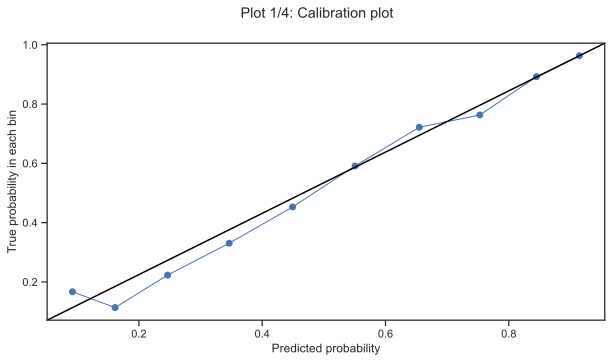

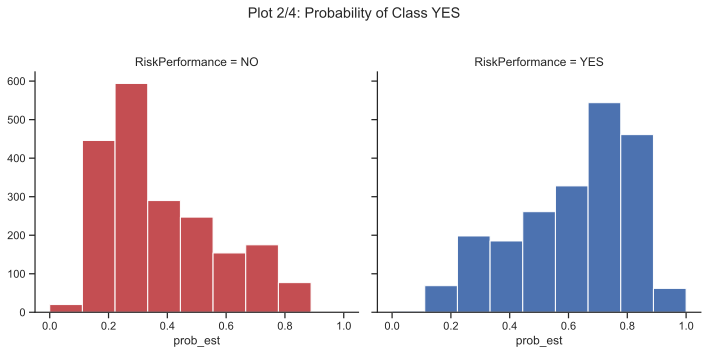

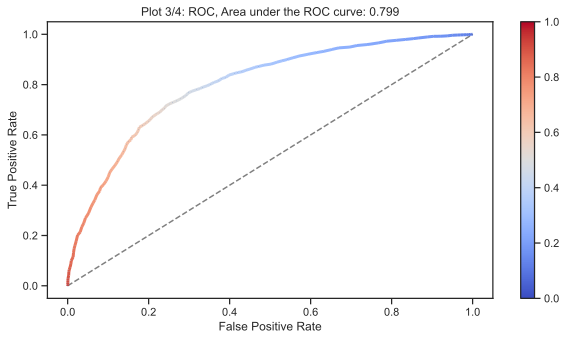

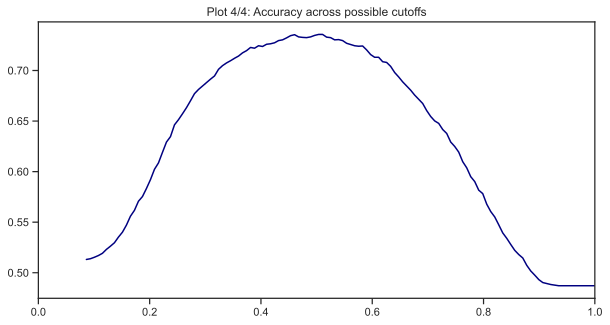

In [307]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'],knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass='YES')

Just like happened with the previous models, we obtain a quite calibrated model with about 0.79 AUC and 73% Accuracy, with balanced sensitivity and specificity.

At least, these are the values we obtain while training our model and testing it with CV, yet we still need to check how good does the model performs with our test dataset. However, as we trained our model and used CV, we expect the resukts not to differ too much.

In [308]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_knn_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 350  151
      YES 147  381

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.42
Mcnemar's Test P-Value: 0.86
Sensitivity: 0.72
Specificity: 0.7
Precision: 0.7
Recall: 0.7
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.52
Balanced accuracy: 0.71
F1 Score: 0.7
Positive label: NO


We can see how the accuracy, sensitivity and specificitty go down a bit, yet it is just enough to make this KNN one of the worst models we have tried so far.

In order to try to improve these values we have 2 ideas.

1. In the previous model, given a new observation, we have given the same importance to all the 119 closest points to this observation, independently of their distance to the point. From now on, we will make the distance of every neighbour to our observation have an impact in the estimated probability for that observation to be YES or NO.
We do that through the parameter weights="distance" in the function that models KNN.

2. We mentioned earlier that it would be huge for our model to remove those variables without a big relation with Y, as those will add a lot of noise to the model. Based on their significativity on the logistic regressions model, we will decide to remove the least significant variables. 

#### 3.2:KNN with distance weights 

We make the distance of the neighbours be a decisive factor in this model, and check if our results improve at all.

There is no change in the inputs nor the values of the grid that we use for this model.

In [309]:
# Scale data previous to fit
#Here we include that the distance to the observations must be considered
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(weights="distance"))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("kNN Trained")

kNN Trained


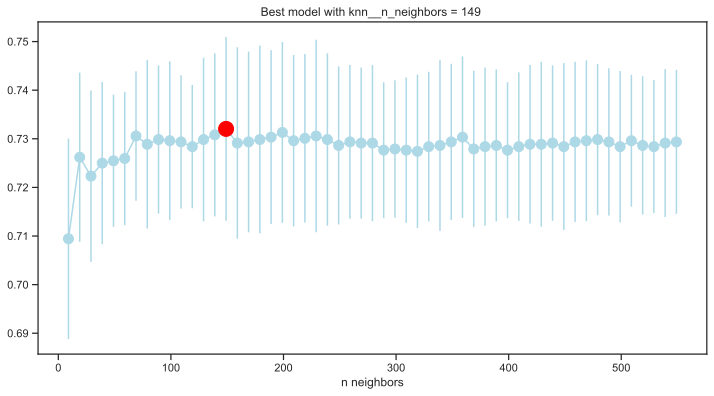

In [310]:
MT.plotModelGridError(knn_fit)

It feels like the improvement in the accuracy is almost inexistent, probably because of the noise added by the non-significant variables. Anyway, we calculate the rest of values such as the confusion matrix or plots like the ROC curve, in order to gig a little deeper in the model.

In [311]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn2_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn2_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn2_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn2_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn2_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn2_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [315]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_knn2_pred'], labels=['NO','YES'])
print(dfTR_eval["RiskPerformance"]==dfTR_eval['Y_knn2_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 2005    0
      YES    0 2111

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.51
Detection Rate: 0.51
Detection prevalence: 0.51
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: NO
7070    True
4049    True
3664    True
3008    True
6137    True
        ... 
2661    True
3536    True
6248    True
6348    True
2352    True
Length: 4116, dtype: bool


### MODEL 4: DECISION TREES

### MODEL 5: RANDOM FOREST

### MODEL 6: SUPPORT VECTOR MACHINES (SVM)

The next model that we are going to implement will be Support Vector Machines. This classification algorithm performs well with only two classes, and using a kernel different from the linear one non-linear classification problems can be solved.

For that reason, we could use a grid to change between different cost terms (a lower cost term means that less errors are permitted: narrow margins that are rarely violated). Before showing the results, it seems that we need a higher C cost term in order to have a more biased classifier but with lower variance. It is important to indicate that we will use the selection of variables commented above, due to the fact that results are better and the interpretation is simpler.

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS

param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=150))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

print("Linear SVM Model Trained")